In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import os
import sys

from dataset import COCO_DETECTION
from torchvision.datasets import CocoDetection

/opt/homebrew/anaconda3/envs/adlcv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check the dataset class without augmentation

In [3]:
dataset = COCO_DETECTION("../coco2017/val2017", "../coco2017/annotations/instances_val2017.json", categories=['horse'])

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [4]:
import random
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        x1, y1, width, height = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), width, height, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

In [5]:
test = dataset[0]

In [6]:
test['image'].shape, len(test['masks']), len(test['bboxes'])

((361, 640, 3), 2, 2)

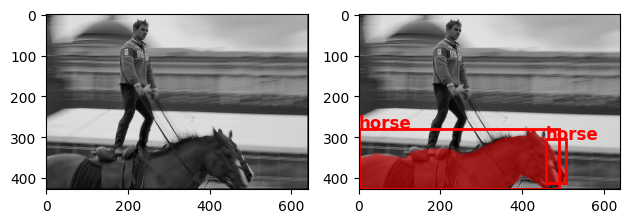

In [7]:
test = dataset[random.randint(0, len(dataset))]
f, ax = plt.subplots(1, 2)
ax[0].imshow(test['image'])

for i, mask in enumerate(test['masks']):
    color = random_colors(1)[0]
    img = apply_mask(test['image'], mask, color)
    ax[1].imshow(img)
    x, y, width, height = test['bboxes'][i][:4]
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    
    # Add text to the rectangle
    label = f"horse"
    ax[1].text(x, y, label, color='r', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


# Check with augmentation, but no copy-paste

In [8]:
import albumentations as A

transform = A.Compose([
        A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(512, 512, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(512, 512, p=1),
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

dataset = COCO_DETECTION("../coco2017/val2017", "../coco2017/annotations/instances_val2017.json", categories=['horse'], transform=transform)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


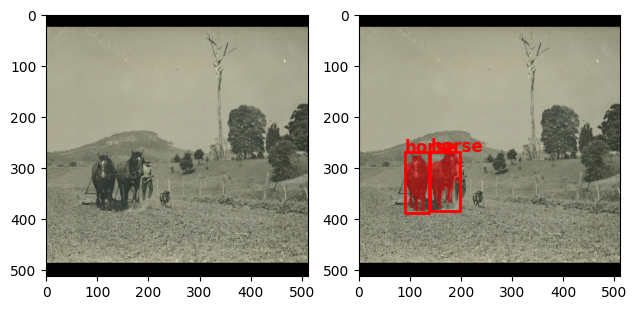

In [9]:
test = dataset[random.randint(0, len(dataset))]
f, ax = plt.subplots(1, 2)
ax[0].imshow(test['image'])
if len(test['bboxes']) == 0:
    pass
else:    
    for i, mask in enumerate(test['masks']):
        color = random_colors(1)[0]
        img = apply_mask(test['image'], mask, color)
        ax[1].imshow(img)
        x, y, width, height = test['bboxes'][i][:4]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        
        # Add text to the rectangle
        label = f"horse"
        ax[1].text(x, y, label, color='r', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

# Creating the Copy-Paste Transformation

In [10]:
import pickle
import zlib

def read_and_decompress(file):
    # Read the compressed mask from the pickle file
    with open(file, "rb") as f:
        compressed_mask = pickle.load(f)
    # Decompress the mask
    decompressed_mask = zlib.decompress(compressed_mask)
    # Convert the decompressed mask to numpy array
    mask = np.frombuffer(decompressed_mask, dtype=np.bool_)
    n = np.sqrt(len(mask)).astype(int)
    mask = mask.reshape((n, n))
    return mask


In [11]:
from glob import glob
import os

class SynData(torch.utils.data.Dataset):

    def __init__(self, img_dir, mask_dir):
        self.syn_imgs = sorted(glob(os.path.join(img_dir, "*.jpg")))
        self.syn_lbls = sorted(glob(os.path.join(mask_dir, "*.pkl")))
        assert len(self.syn_imgs) == len(self.syn_lbls), "Number of image and mask files do not match."

    def get_transform(self):
        img_size = random.randint(64,256)
        return A.Compose([
            A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
            A.PadIfNeeded(img_size, img_size, border_mode=0), #pads with image in the center, not the top left like the paper
            A.Resize(img_size, img_size, p=1),
            #A.RandomCrop(img_size, img_size, p=1),            
            #A.RandomResizedCrop(img_size, img_size, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), p=1),
            A.HorizontalFlip(p=0.5),
            #A.RandomRotate90(p=0.5),
        ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05))

    def _get_bbox(self, mask):
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        assert len(np.where(rows)[0]) > 0
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        assert ymax >= ymin and xmax >= xmin
        return [int(xmin), int(ymin), int(xmax)-int(xmin), int(ymax)-int(ymin)]

    def __len__(self):
        return len(self.syn_imgs)
    
    def __getitem__(self, idx):
        output = self._get_syn_data(idx)
        transform = self.get_transform()

        output = transform(**output)
        return output

    def _get_syn_data(self, idx):
        """
        Get synthetic data
        """
        # Load synthetic image
        syn_img = Image.open(self.syn_imgs[idx]).convert("RGB")
        syn_img = np.array(syn_img)
        # Load synthetic mask
        syn_mask = read_and_decompress(self.syn_lbls[idx])
        syn_mask = syn_mask.astype(np.uint8)
        #syn_bboxes = self._extract_bbox(syn_mask)
        syn_bbox = self._get_bbox(syn_mask)
        syn_bbox = syn_bbox + [19] # Add label to the bounding box # TODO: Change this to a more general solution
        output = {
            "image": syn_img,
            "masks": [syn_mask],
            "bboxes": [syn_bbox]
        }
        return output

In [12]:
syn_dataset = SynData("../horse", "../horse")

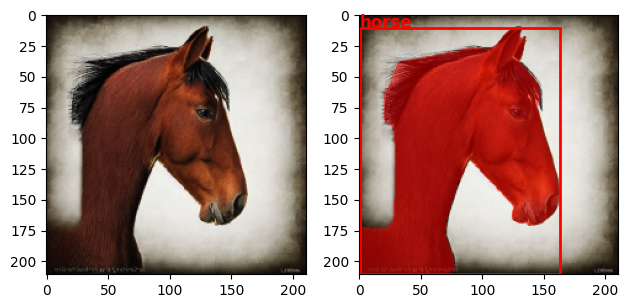

In [13]:
test = syn_dataset[random.randint(0, len(syn_dataset)-1)]
f, ax = plt.subplots(1, 2)
ax[0].imshow(test['image'])
if len(test['bboxes']) == 0:
    pass
else:    
    for i, mask in enumerate(test['masks']):
        color = random_colors(1)[0]
        img = apply_mask(test['image'], mask, color)
        ax[1].imshow(img)
        x, y, width, height = test['bboxes'][i][:4]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        
        # Add text to the rectangle
        label = f"horse"
        ax[1].text(x, y, label, color='r', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

## Instance Retriever

In [14]:
class InstanceRetriever():
    def __init__(self, instance_pool:torch.utils.data.Dataset):
        self.instance_pool = instance_pool

    def get_instances(self, n_instances:int):
        # n_instances = random.randint(1, n_instances) #? Maybe to vary the number of instances pasted
        instances = []
        for i in range(n_instances):
            instances.append(self.instance_pool[random.randint(0, len(self.instance_pool)-1)])
        return instances

    

In [15]:
instance_retriever = InstanceRetriever(syn_dataset)

In [16]:
instances = instance_retriever.get_instances(5)

In [17]:
instances[0]['bboxes']

[(31.078125, 43.330078125, 118.3359375, 95.923828125, 19)]

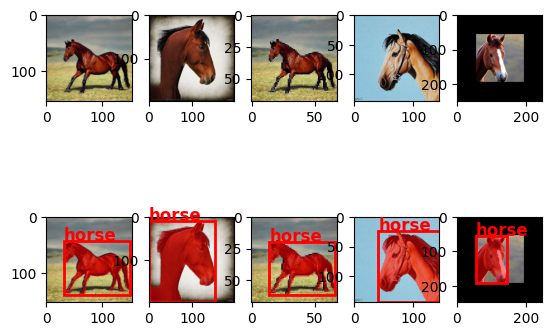

In [18]:

f, ax = plt.subplots(2, len(instances))
for idx, test in enumerate(instances):
    ax[0,idx].imshow(test['image'])
    if len(test['bboxes']) == 0:
        pass
    else:    
        for i, mask in enumerate(test['masks']):
            color = random_colors(1)[0]
            img = apply_mask(test['image'], mask, color)
            ax[1, idx].imshow(img)
            x, y, width, height = test['bboxes'][i][:4]
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax[1, idx].add_patch(rect)
            
            # Add text to the rectangle
            label = f"horse"
            ax[1, idx].text(x, y, label, color='r', fontsize=12, weight='bold')


## Copy-Paste Transformation

In [19]:
class InstanceCopyPaste():

    def __init__(self, instance_retriever:InstanceRetriever, layering:str, n_instances:int, min_visible_pct:float=1.0, min_visible_keyspoint:int = 10):
        self.instance_retriever = instance_retriever
        self.min_visible_pct = min_visible_pct
        self.n_instances = n_instances
        self.layering = layering # TODO: Implement the layering
        self.min_visible_keyspoint = min_visible_keyspoint
    def __call__(self, image, masks, bboxes):
        return self.copy_paste(image, masks, bboxes)

    def copy_paste(self, image, masks, bboxes):
        """

        """
        # Background Image
        background = Image.fromarray(image)
        # Collect new instances to paste onto the background
        instances = self.instance_retriever.get_instances(self.n_instances)
        new_masks = []
        new_bboxes = []

        for instance in instances:
            background, new_instance_mask, new_instance_bbox = self._paste_single_instance(instance['image'], instance['masks'][0], background)
            new_instance_bbox = new_instance_bbox + [instance['bboxes'][0][4]] # Add label to the bounding box
            new_masks.append(new_instance_mask)
            new_bboxes.append(new_instance_bbox)
        #print(len(new_masks), len(new_bboxes))
        #print(bboxes)
        bboxes.extend(new_bboxes)
        masks.extend(new_masks)
        #print(len(masks), len(bboxes))
        adjusted_masks, adjusted_bboxes = self._adjust_masks_and_bboxes(masks, bboxes)
        
        return {"image": np.array(background), "masks": adjusted_masks, "bboxes": adjusted_bboxes}

    # def _adjust_masks_and_bboxes(self, masks, bboxes):
    #     """
    #     Adjust the masks and bounding boxes to account for the new instances pasted onto the background.
    #     """
    #     # Adjust the segmentation masks
    #     masks = np.stack(masks, axis=0)
        
    #     # Create a cumulative presence mask
    #     cumulative_presence = np.cumsum(masks, axis=0) > 1

    #     # Calculate the final masks where each one suppresses the area covered by any previous masks
    #     suppressed_masks = masks * np.logical_not(cumulative_presence)
    #     # Reverse the order of the masks to align with the orignal order
    #     suppressed_masks = suppressed_masks[::-1, :, :]
    #     # Make into a list of masks
    #     new_masks = list(masks)
    #     # Will be used for removing masks with too few key points visible after the suppression
    #     visible_keypoints_per_mask = suppressed_masks.sum(axis=(1, 2))

    #     # Adjust the bounding boxes and remove masks with too few key points visible
    #     adjusted_bboxes = []
    #     adjusted_masks = []
    #     assert len(new_masks) == len(bboxes), "Number of masks and bounding boxes do not match."
    #     assert len(new_masks) == len(visible_keypoints_per_mask), "Number of masks and visible keypoints do not match."
    #     for i in range(len(visible_keypoints_per_mask)):
    #         if visible_keypoints_per_mask[i] > self.min_visible_keyspoint:
    #             adjusted_masks.append(new_masks[i])
    #             x, y, width, height = self.extract_bbox(new_masks[i])
    #             adjusted_bboxes.append([(x, y, width, height, bboxes[i][4])])
    #     return adjusted_masks, adjusted_bboxes
    def _adjust_masks_and_bboxes(self, masks, bboxes):
        # Stack masks into a 3D numpy array
        masks = np.stack(masks, axis=0)

        # Get the index of the highest priority mask for each pixel
        highest_priority_mask = np.argmax(masks[::-1], axis=0)
        highest_priority_mask = masks.shape[0] - 1 - highest_priority_mask
        
        # Create an array where each mask is compared to the highest priority mask
        final_masks = np.zeros_like(masks)
        for i in range(masks.shape[0]):
            final_masks[i] = (highest_priority_mask == i) * masks[i]

        # Convert array back to the list of masks
        new_masks = list(final_masks)
        
        # Compute visibility of keypoints per mask
        visible_keypoints_per_mask = final_masks.sum(axis=(1, 2))

        # Adjust the bounding boxes and remove masks with too few key points visible
        adjusted_bboxes = []
        adjusted_masks = []
        assert len(new_masks) == len(bboxes), "Number of masks and bounding boxes do not match."
        assert len(new_masks) == len(visible_keypoints_per_mask), "Number of masks and visible keypoints do not match."
        
        for i in range(len(visible_keypoints_per_mask)):
            if visible_keypoints_per_mask[i] > self.min_visible_keyspoint:
                adjusted_masks.append(new_masks[i])
                x, y, width, height = self.extract_bbox(new_masks[i])
                adjusted_bboxes.append([(x, y, width, height, bboxes[i][4])])
        
        return adjusted_masks, adjusted_bboxes
    
    def extract_bbox(self, mask):
        """
        Extract the bounding box from a segmentation mask.
        Output format is (x1,y1,w,h).
        """
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        assert len(np.where(rows)[0]) > 0
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        assert ymax >= ymin and xmax >= xmin
        return int(xmin), int(ymin), int(xmax)-int(xmin), int(ymax)-int(ymin)
      
    # TODO: Implement the layering
    #! DOES NOT WORK YET
    def _collect_bg_instance(self, image, masks, bboxes):
        """
        Collect background instances such these 
        can be pasted onto the background 
        image on top of other new instances.
        """
        insts = zip(masks, bboxes)
        bg_insts = []
        for mask, bbox in insts:
            cropped_image = self._crop_image(image, bbox)
            cropped_mask = self._crop_image(mask, bbox)

            bg_insts.append({
                'image': cropped_image,
                'masks': cropped_mask,
                'bboxes': bbox
            })
        return bg_insts

    def _crop_image(self, image, bbox):
        """
        Crop an image given a bounding box.
        """
        x, y, width, height = bbox
        return image[y:y+height, x:x+width]

    # TODO: There is a bug in the pasting of the image
    # TODO: sometimes it will have a mismatch with the effective mask and so fort
    def _paste_single_instance(self, image, mask, background):
        """
        Paste a segmented part of an image such that at least 25% of it remains within
        the background image boundaries.
        
        Args:
        image (PIL.Image): Input image of size n by n.
        mask (numpy.array): Segmentation mask, same dimensions as image.
        bbox (tuple): Bounding box (xmin, ymin, xmax, ymax).
        background (PIL.Image): Background image to paste onto.
        
        Returns:
        PIL.Image: Modified background image with the pasted segment.
        numpy.array: Updated segmentation mask.
        tuple: Updated bounding box (xmin, ymin, xmax, ymax).
        """
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        if not isinstance(background, Image.Image):
            background = Image.fromarray(background)
        # Convert the segmentation mask to a PIL image and extract the region
        mask_image = Image.fromarray((mask * 255).astype(np.uint8))
        segmented_part = Image.composite(image, Image.new('RGB', image.size), mask_image)

        # Calculate the range for the random location
        # Allowing part of the image to be outside the background
        min_x = int(-(1-self.min_visible_pct) * image.width)
        max_x = int(background.width - self.min_visible_pct * image.width)
        min_y = int(-(1-self.min_visible_pct) * image.height)
        max_y = int(background.height - self.min_visible_pct * image.height)

        random_x = random.randint(min_x, max_x)
        random_y = random.randint(min_y, max_y)

        # Paste the segmented part onto the background
        background.paste(segmented_part, (random_x, random_y), mask_image)

        # Update the mask and bounding box
        new_mask = np.zeros((background.height, background.width), dtype=np.uint8)
        #! This is where the bug is (below)
        # Calculate the effective coordinates considering possible negative indices
        effective_x = max(random_x, 0)
        effective_y = max(random_y, 0)
        effective_width = min(segmented_part.width, background.width - effective_x)
        effective_height = min(segmented_part.height, background.height - effective_y)
        #print("New Mask Indices:", effective_y, effective_y + effective_height, effective_x, effective_x + effective_width)
        #print("Mask Indices:",  max(-random_y, 0),  max(-random_y, 0) + effective_height, max(-random_x, 0), max(-random_x, 0) + effective_width)

        new_mask[effective_y:effective_y + effective_height, effective_x:effective_x + effective_width] = mask[
            max(-random_y, 0):max(-random_y, 0) + effective_height,
            max(-random_x, 0):max(-random_x, 0) + effective_width
        ]

        new_bbox = [
            effective_x,
            effective_y,
            effective_x + effective_width,
            effective_y + effective_height
        ]
        return background, new_mask, new_bbox


In [20]:
import albumentations as A

transform = A.Compose([
        A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(512, 512, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(512, 512, p=1),
    ], bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)

dataset = COCO_DETECTION("../coco2017/val2017", "../coco2017/annotations/instances_val2017.json", categories=['horse'], transform=transform, instance_copy_paste = InstanceCopyPaste(instance_retriever, "random", 5, 1, 10))

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


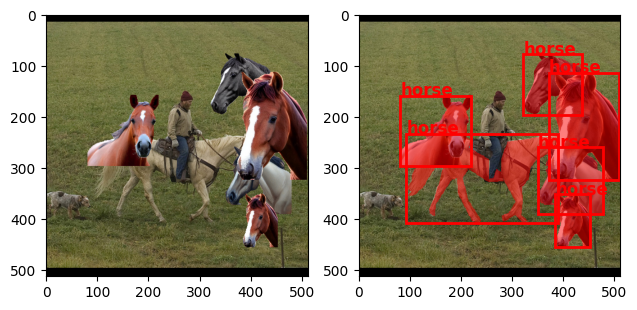

In [22]:
test = dataset[random.randint(0, len(dataset)-1)]
#test = ICP(**test)
f, ax = plt.subplots(1, 2)
ax[0].imshow(test['image'])
if len(test['bboxes']) == 0:
    pass
else:    
    for i, mask in enumerate(test['masks']):
        color = random_colors(1)[0]
        img = apply_mask(test['image'], mask, color)
        ax[1].imshow(img)
    
        x, y, width, height, _ = test['bboxes'][i][0]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        
        # Add text to the rectangle
        label = f"horse"
        ax[1].text(x, y, label, color='r', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

In [23]:
np.unique(np.stack(test['masks'], axis = 0).sum(axis=0)>1)

array([False])